In [32]:
# !pip freeze -> requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from PIL import Image
import os
import string
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

(500, 37, 120, 1)


Text(0.5, 1.0, '7713')

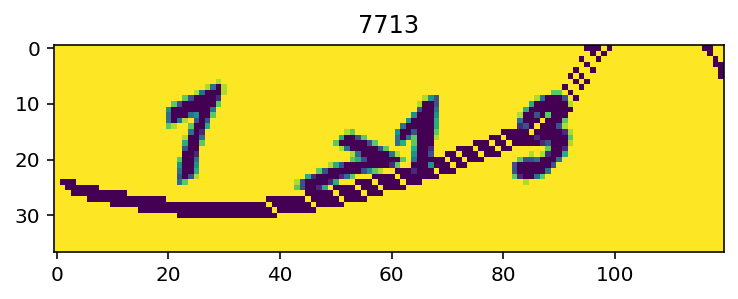

In [47]:
#hyperparameters
characters = string.digits
width, height, n_len, n_class = 120, 37, 4, len(characters)

#img_path
train_img_path = ["train\\captcha-" + str(i) for i in range(1,6)]
img_list = [os.listdir(train_img_path[i]) for i in range(5)]

#tf config
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

#get trainning batch
def get_batch(characters, batch_size, n_len, n_class, width, height):
    
    X = np.zeros((batch_size, height, width, 1), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]

    for i in range(batch_size): 
    
        rand = random.randint(0,4)
        img_name = random.choice(img_list[rand])
        img_file = os.path.join(train_img_path[rand], img_name)
        img = Image.open(img_file).convert('L')
        img = img.resize((width, height))
        X[i] = np.array(img).reshape(height,width,1) / 255.0
        for j, ch in enumerate(img_name[:4]):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1  
           
    return X, y
      
#show results       
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

#test above code
X,y = get_batch(characters, 500, n_len, n_class, width, height)
print(X.shape)
plt.imshow(X[0].reshape(height,width), cmap='gray')
plt.title(decode(y))

In [49]:
#define model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 1))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [50]:
#train
def train_model(model):
    from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam

    callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-3, amsgrad=True), 
                  metrics=['accuracy'])

    X_train,y_train = get_batch(characters, 2000, n_len, n_class, width, height)
    model.fit(X_train, y_train, validation_split=0.1 ,epochs=10, batch_size=128, workers=4, use_multiprocessing=True, callbacks=callbacks)   
    return model

In [51]:
model = train_model(model)

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1800/1800 [==============================] - 41s 23ms/sample - loss: 10.5317 - c1_loss: 2.7431 - c2_loss: 2.6001 - c3_loss: 2.5964 - c4_loss: 2.5156 - c1_acc: 0.0939 - c2_acc: 0.1011 - c3_acc: 0.0967 - c4_acc: 0.1117 - val_loss: 41.2272 - val_c1_loss: 10.4270 - val_c2_loss: 6.4451 - val_c3_loss: 15.8389 - val_c4_loss: 8.5020 - val_c1_acc: 0.0850 - val_c2_acc: 0.1150 - val_c3_acc: 0.1050 - val_c4_acc: 0.1000
Epoch 2/10
1800/1800 [==============================] - 37s 20ms/sample - loss: 9.4121 - c1_loss: 2.3383 - c2_loss: 2.3706 - c3_loss: 2.3306 - c4_loss: 2.3691 - c1_acc: 0.1228 - c2_acc: 0.1256 - c3_acc: 0.1294 - c4_acc: 0.1228 - val_loss: 17.7180 - val_c1_loss: 3.5505 - val_c2_loss: 4.1151 - val_c3_loss: 3.3978 - val_c4_loss: 6.5129 - val_c1_acc: 0.1000 - val_c2_acc: 0.0800 - val_c3_acc: 0.1050 - val_c4_acc: 0.1000
Epoch 3/10
1800/1800 [==============================] - 37s 20ms/sample - loss: 9.1832 - c1_loss: 2.2738 - c2_lo

In [75]:
def retrain_model(model):
    from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    model.load_weights('cnn_best.h5')
    
    callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
                 ModelCheckpoint('cnn_best.h5', save_best_only=True)]

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-4, amsgrad=True), 
                  metrics=['accuracy'])
    X_train,y_train = get_batch(characters, 10000, n_len, n_class, width, height)
    model.fit(X_train, y_train, validation_split=0.1 ,epochs=20, batch_size=128, workers=4, use_multiprocessing=True, callbacks=callbacks)   
    return model

In [76]:
#retrain with cnn_best.h5
model = retrain_model(model)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 197s 22ms/sample - loss: 8.1602 - c1_loss: 1.9578 - c2_loss: 2.0366 - c3_loss: 2.0475 - c4_loss: 2.1119 - c1_acc: 0.2617 - c2_acc: 0.2303 - c3_acc: 0.2270 - c4_acc: 0.2032 - val_loss: 9.9647 - val_c1_loss: 2.4783 - val_c2_loss: 2.5620 - val_c3_loss: 2.5095 - val_c4_loss: 2.4189 - val_c1_acc: 0.1110 - val_c2_acc: 0.1040 - val_c3_acc: 0.0920 - val_c4_acc: 0.1070
Epoch 2/20
9000/9000 [==============================] - 195s 22ms/sample - loss: 5.9985 - c1_loss: 1.3506 - c2_loss: 1.5156 - c3_loss: 1.5161 - c4_loss: 1.6042 - c1_acc: 0.4940 - c2_acc: 0.4340 - c3_acc: 0.4243 - c4_acc: 0.4109 - val_loss: 10.1385 - val_c1_loss: 2.5522 - val_c2_loss: 2.4967 - val_c3_loss: 2.5644 - val_c4_loss: 2.5314 - val_c1_acc: 0.1470 - val_c2_acc: 0.1110 - val_c3_acc: 0.1220 - val_c4_acc: 0.1230
Epoch 3/20
9000/9000 [==============================] - 199s 22ms/sample - loss: 3.8381 - c1_loss: 0.8084 - c2_lo

9000/9000 [==============================] - 201s 22ms/sample - loss: 0.0402 - c1_loss: 0.0086 - c2_loss: 0.0099 - c3_loss: 0.0105 - c4_loss: 0.0113 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - val_loss: 0.8736 - val_c1_loss: 0.1665 - val_c2_loss: 0.2097 - val_c3_loss: 0.2490 - val_c4_loss: 0.2498 - val_c1_acc: 0.9430 - val_c2_acc: 0.9290 - val_c3_acc: 0.9230 - val_c4_acc: 0.9260


(-0.5, 119.5, 36.5, -0.5)

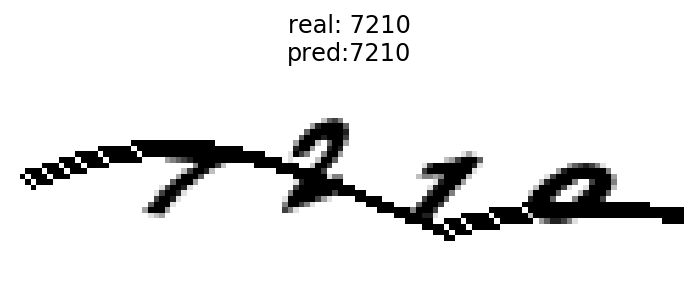

In [101]:
model.load_weights('cnn_best.h5')

#test model
X,y = get_batch(characters, 1, n_len, n_class, width, height)
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0].reshape(height,width), cmap='gray')
plt.axis('off')

In [104]:
#evaluate
# def evaluate(model, batch_num=1000):
#     batch_acc = 0
#     X,y = get_batch(characters, batch_num, n_len, n_class, width, height)

#     y_pred = model.predict(X)
#     y_pred = np.argmax(y_pred, axis=-1).T
#     y_true = np.argmax(y, axis=-1).T

#     batch_acc += (y_true == y_pred).all(axis=-1).mean()
#     return batch_acc / batch_num

# evaluate(model)

In [102]:
test_imgs = os.getcwd() + "\\test"
img_names = []
for file_name in os.listdir(test_imgs):
    if file_name[-3:] in ['jpg', 'png']:
        img_names.append(file_name)

img_paths = [test_imgs+"\\"+img_name for img_name in img_names]
print(img_paths[:2])

['C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\test\\3996.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\test\\3996.png']


D:\dev_tools\Anaconda3_2019.07\lib\site-packages\tensorflow\python\keras\api\_v1\keras\layers\__init__.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from tensorflow.python.feature_column.feature_column_lib import Layer


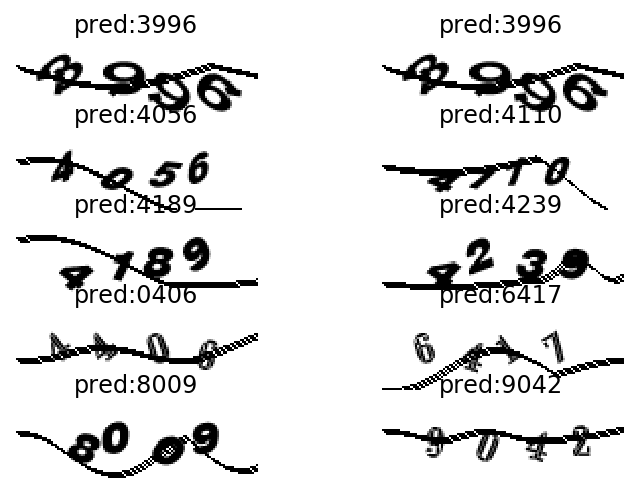

In [103]:
for i,img_path in enumerate(img_paths[:10]):    
    img = Image.open(img_path).convert('L')
    img = img.resize((width, height))
    x = np.array(img).reshape(height,width,1) / 255.0
    x = x[np.newaxis,:]
    y_pred = model.predict(x)
    x.shape
    plt.subplot(5,2,i+1).title.set_text('pred:%s'%(decode(y_pred)))
    plt.subplot(5,2,i+1).imshow(x[0].reshape(height,width), cmap='gray')
    plt.axis('off')